In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
pd.set_option("max_columns",125)

In [2]:
df_train = pd.read_csv("credit_history_train.csv")

In [3]:
df_train.head()

,ID,CREDIT,GENDER,EDUCATION,MARRIAGE,AGE,PAY_FEB,PAY_JAN,PAY_DEC,BILL_AMT_FEB,BILL_AMT_JAN,BILL_AMT_DEC,PAY_AMT_FEB,PAY_AMT_JAN,PAY_AMT_DEC,DEFAULT_MAR
0,1,20000,Female,Post Graduate,Married,24,2,2,-1,3913,3102,689,0,689,0,1
1,2,120000,Female,Post Graduate,Single,26,-1,2,-1,2682,1725,2682,0,1000,1000,1
2,3,90000,Female,Post Graduate,Single,34,-1,-1,-1,29239,14027,13559,1518,1500,1000,0
3,4,50000,Female,Post Graduate,Married,37,-1,-1,-1,46990,48233,49291,2000,2019,1200,0
4,5,50000,Male,Post Graduate,Married,57,-1,-1,-1,8617,5670,35835,2000,36681,10000,0


In [4]:
## Some basic sanity checks for the 3 data frame 
def nulldata(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending = False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()*100).sort_values(ascending = False)
    df_null=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return(df_null)

print(nulldata(df_train))

              Total  Percent
DEFAULT_MAR       0      0.0
PAY_AMT_DEC       0      0.0
PAY_AMT_JAN       0      0.0
PAY_AMT_FEB       0      0.0
BILL_AMT_DEC      0      0.0
BILL_AMT_JAN      0      0.0
BILL_AMT_FEB      0      0.0
PAY_DEC           0      0.0
PAY_JAN           0      0.0
PAY_FEB           0      0.0
AGE               0      0.0
MARRIAGE          0      0.0
EDUCATION         0      0.0
GENDER            0      0.0
CREDIT            0      0.0
ID                0      0.0


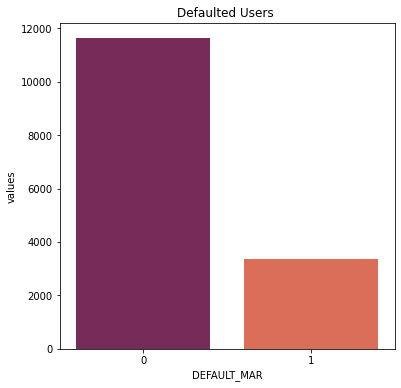

0    11623
1     3377
Name: DEFAULT_MAR, dtype: int64


In [5]:
## We check for any class imbalance in the labelled data set
## Also we check if country code also have an impact on churn
temp = df_train["DEFAULT_MAR"].value_counts()
df = pd.DataFrame({'DEFAULT_MAR': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Defaulted Users ')
sns.set_color_codes("pastel")
sns.barplot(x = 'DEFAULT_MAR', y="values", data=df,palette="rocket")
locs, labels = plt.xticks()
plt.show()
print(temp)

In [6]:
# Default Percentage
100*df_train.groupby('DEFAULT_MAR')["ID"].count()/len(df_train)

DEFAULT_MAR
0    77.486667
1    22.513333
Name: ID, dtype: float64

**22.5% of the users defaulted in the month of MARCH**

There is a class imbalance in the data, quite expectedly so and we will handle it in due course of analysis and model building

We now move on the explore all the other variables to understand their distribution and discrepancies in them if any

In [7]:
## Analysing the CATEGORICAL VARIABLES and their distribution too Default and Non default cases

In [8]:
def get_data_crosstab(dataframe,label_column,feature_column):
    data_crosstab = pd.crosstab(dataframe[label_column], dataframe[feature_column], margins=True, normalize=False)
    new_index = {1: 'DEFAULT', 0: 'NO_DEFAULT', }
    data_crosstab.rename(index=new_index,inplace=True)
    distribution_output=data_crosstab/data_crosstab.loc['All']
    return distribution_output,data_crosstab

In [9]:
get_data_crosstab(df_train,"DEFAULT_MAR","GENDER")

(GENDER        Female     Male       All
 DEFAULT_MAR                            
 NO_DEFAULT   0.78621  0.75944  0.774867
 DEFAULT      0.21379  0.24056  0.225133
 All          1.00000  1.00000  1.000000,
 GENDER       Female  Male    All
 DEFAULT_MAR                     
 NO_DEFAULT     6796  4827  11623
 DEFAULT        1848  1529   3377
 All            8644  6356  15000)

In [10]:
get_data_crosstab(df_train,"DEFAULT_MAR","EDUCATION")

(EDUCATION    Doctorate  Graduate  High School  Others  Post Graduate       All
 DEFAULT_MAR                                                                   
 NO_DEFAULT    0.945946  0.793688     0.750212  0.9375       0.764012  0.774867
 DEFAULT       0.054054  0.206312     0.249788  0.0625       0.235988  0.225133
 All           1.000000  1.000000     1.000000  1.0000       1.000000  1.000000,
 EDUCATION    Doctorate  Graduate  High School  Others  Post Graduate    All
 DEFAULT_MAR                                                                
 NO_DEFAULT          35      4451         1769     120           5248  11623
 DEFAULT              2      1157          589       8           1621   3377
 All                 37      5608         2358     128           6869  15000)

In [11]:
get_data_crosstab(df_train,"DEFAULT_MAR","MARRIAGE")

(MARRIAGE      Married    Others    Single       All
 DEFAULT_MAR                                        
 NO_DEFAULT   0.760434  0.794258  0.786117  0.774867
 DEFAULT      0.239566  0.205742  0.213883  0.225133
 All          1.000000  1.000000  1.000000  1.000000,
 MARRIAGE     Married  Others  Single    All
 DEFAULT_MAR                                
 NO_DEFAULT      5047     166    6410  11623
 DEFAULT         1590      43    1744   3377
 All             6637     209    8154  15000)

We see than GENDER EDUCATION and MARTITAL STATUS doesn't provide a significant impact of DEFAULT rate. 

The categories of EDUCATION with fairly large deviation from the overall average is due to quite less number of records which are not significant enough to be considered as quite impactful

In [12]:
## Analysing the CONTINOUS VARIABLES and their distribution too Default and Non default cases

In [13]:
def get_data_distrib(data_frame,label_column,feature_column):
    df_default = data_frame[data_frame[label_column] == 1]
    df_no_default = data_frame[data_frame[label_column] == 0]
    df_default["DEFAULT"] = df_default[feature_column]
    df_no_default["NO_DEFAULT"] = df_no_default[feature_column]
    f, ax = plt.subplots(figsize=(12, 6))
    ax = sns.kdeplot(df_default["DEFAULT"], shade=True, color="r")
    ax = sns.kdeplot(df_no_default["NO_DEFAULT"], shade=True, color="g")
    plt.title('Density plot by'+feature_column+'.')
    
    

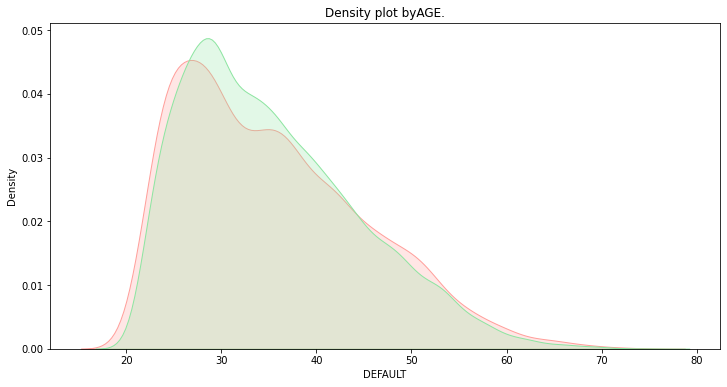

In [14]:
get_data_distrib(df_train,"DEFAULT_MAR","AGE")

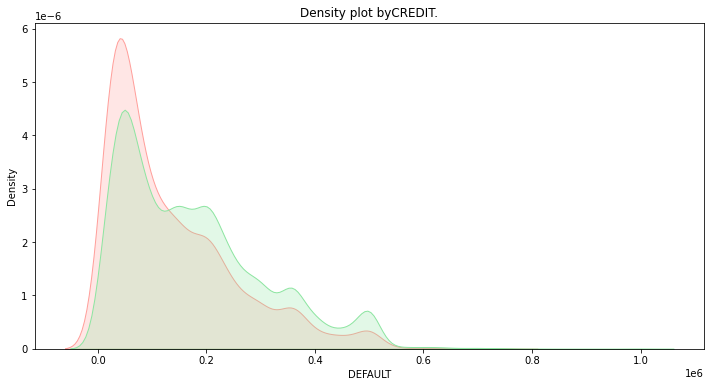

In [15]:
get_data_distrib(df_train,"DEFAULT_MAR","CREDIT")

<AxesSubplot:title={'center':'Correlation between the continuous variables'}>

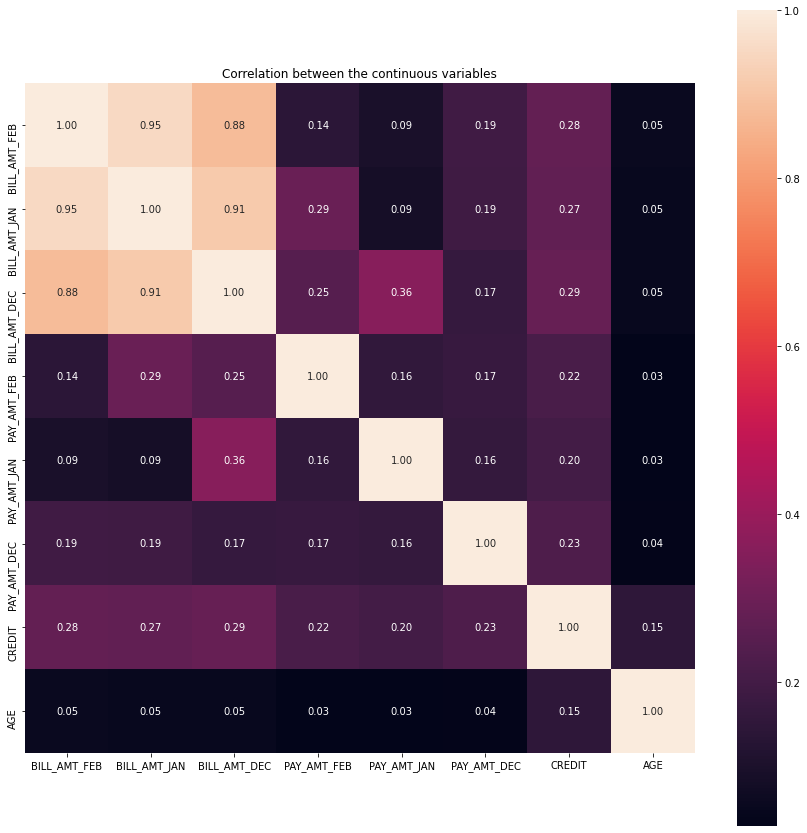

In [16]:
var = ['BILL_AMT_FEB','BILL_AMT_JAN','BILL_AMT_DEC','PAY_AMT_FEB','PAY_AMT_JAN','PAY_AMT_DEC',"CREDIT","AGE"]

plt.figure(figsize = (15,15))
plt.title('Correlation between the continuous variables')
corr = df_train[var].corr()
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Observations

1. As we see from the distribution of AGE, TOTAL CREDIT and the correlation of all the categorical varaibles it seems they are fairly independent to each other. The overall BILL AMOUNT of 3 months which shows high correlation can be attributed to the nature of business and since we know all months are independent of each other the correlation is not of importance in this case.

2. Also the probability of default rate is not significantly different to non default rate w.r.t AGE.

3. There is a slightly higher rate of DEFAULT for SMEs with smaller CREDIT.



One important factor can be continuity in payments and hence we create a feature to ascertain continuity of payments by SMEs


Let's look into continuity of pay to DEFAULT. Here all payments default code are in the range (-1..n) so for 3 months the best score can be -3. Checking the payment default codes' sum and their distribution to default

In [17]:
df_train["sum_code"]=df_train.apply(lambda row:row.PAY_FEB+row.PAY_JAN+row.PAY_DEC,axis=1)
perc_tab,data_tab=get_data_crosstab(df_train,"DEFAULT_MAR","sum_code")

In [18]:
pd.DataFrame(perc_tab).transpose().reset_index().sort_values("DEFAULT",ascending=False)

DEFAULT_MAR,sum_code,NO_DEFAULT,DEFAULT,All
17,16,0.000000,1.000000,1.0
18,17,0.000000,1.000000,1.0
12,10,0.214286,0.785714,1.0
9,7,0.274336,0.725664,1.0
11,9,0.311111,0.688889,1.0
8,6,0.313070,0.686930,1.0
10,8,0.326531,0.673469,1.0
16,15,0.333333,0.666667,1.0
14,12,0.384615,0.615385,1.0
6,4,0.457627,0.542373,1.0


In [19]:
## Creating a BASELINE MODELS with no feature engineering and using all the features

### Pointers to Baseline Model

1. The idea is to create a model with all the available features with and without balancing for class imbalance. This will help us get an idea about how the error and the basic metrics for classification looks like.
2. We also look at the data distribution to choose the kind of models we want to test the baseline on and for that we do Shapiro test to determine if the training data follows a gaussian distribution

In [20]:
## Testing for gaussian distribution

from scipy.stats import shapiro

columns=["AGE","CREDIT","PAY_AMT_FEB","PAY_AMT_JAN","PAY_AMT_DEC","BILL_AMT_FEB","BILL_AMT_JAN","BILL_AMT_DEC"]
for column in columns:
    stat, p = shapiro(df_train["PAY_AMT_JAN"])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        
        print(column+' Sample looks Gaussian (fail to reject H0)')
    else:
        print(column+ 'Sample does not look Gaussian (reject H0)')

Statistics=0.178, p=0.000
AGESample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
CREDITSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
PAY_AMT_FEBSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
PAY_AMT_JANSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
PAY_AMT_DECSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
BILL_AMT_FEBSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
BILL_AMT_JANSample does not look Gaussian (reject H0)
Statistics=0.178, p=0.000
BILL_AMT_DECSample does not look Gaussian (reject H0)


### Pointers for Model Building
Since none of the numerical variables have a gaussian distribution it makes no sense to use a Linear Model for classification e.g. Logsitic Regression and hence we use various tree based models to build the base line

Few arguments in favour of these type of algorithms are:
1. They are non-parametric and don’t assume or require the data to follow a particular distribution: this will save you time transforming data to be normally distributed
2. They can handle mixed data types: categorical variables do not necessarily have to be one hot encoded
3. Multi-collinearity of features does not affect the accuracy and prediction performance of the model: features do not need to be removed or otherwise engineered to decrease the correlations and interactions between them
4. They are robust against overfitting: because they use many weak learners that underfit (high bias) and combine those predictions into a stronger learner, they reduce the overfitting (variance) of the model.
5. Inputs do not need to be scaled: preprocessing and transforming the features with MinMaxScaler or StandardScaler are not necessary
6. They are computationally relatively inexpensive: compared to algorithms such as Support Vector Machines or neural networks they are faster


In [21]:
#importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [22]:
## Creating Data for Training and Validation before the model is used in Testing data
## We convert the categorical variables to cat codes for easier computation

In [23]:
df_train["MARRIAGE"]=pd.factorize(df_train["MARRIAGE"])[0]
df_train["GENDER"]=pd.factorize(df_train["GENDER"])[0]
df_train["EDUCATION"]=pd.factorize(df_train["EDUCATION"])[0]

In [24]:
features=["AGE","sum_code","CREDIT","PAY_AMT_FEB","PAY_AMT_JAN","PAY_AMT_DEC","PAY_FEB","PAY_JAN",
          "PAY_DEC","BILL_AMT_FEB","BILL_AMT_JAN","BILL_AMT_DEC","EDUCATION","GENDER","MARRIAGE"]
class_tag="DEFAULT_MAR"


In [25]:
classifiers = {"Decision Tree":DecisionTreeClassifier(max_depth=10, random_state=14),
        'XGBClassifier': XGBClassifier(),
        "RandomForest":RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
        "AdaBoost":AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),
                               n_estimators = 100), 
        "GradientBoosting":GradientBoostingClassifier()}

In [26]:
## Building the baseline model
kf = KFold(n_splits=5,random_state=42,shuffle=True) ## Doing a 4 fold Cross Validation
fold = []
scr = []
models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Accuracy'])

df_final=df_train
for i,(train_index, test_index) in enumerate(kf.split(df_final)):
    training = df_final.iloc[train_index,:]
    valid = df_final.iloc[test_index,:]
    training_feats = training[features] #defined above
    training_label = training[class_tag]

    valid_feats = valid[features]
    valid_label = valid[class_tag]
    for clf, clf_name in zip(classifiers.values(), classifiers.keys()):
        clf.fit(training_feats,training_label) #it is the last one we run, the best one
        pred = clf.predict(valid_feats)
        score = accuracy_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)

        t = pd.Series({ 
                         'Model': clf_name,
                         'Precision_score': metrics.precision_score(valid_label, pred),
                         'Recall_score': metrics.recall_score(valid_label, pred),
                         'F1_score': metrics.f1_score(valid_label, pred),
                         'Accuracy': metrics.accuracy_score(valid_label, pred),
            "AUC_Score":metrics.roc_auc_score(valid_label, pred),
                        'validation_fold':i}
                       )

        models_report = models_report.append(t, ignore_index = True)

[09:23:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:23:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:23:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:23:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [27]:
## Lets look into the baseline models metrics report
models_report.sort_values("F1_score",ascending=False)[:5]

,Model,Precision_score,Recall_score,F1_score,Accuracy,AUC_Score,validation_fold
18,AdaBoost,0.404234,0.601199,0.483424,0.714333,0.673939,3.0
13,AdaBoost,0.402572,0.577305,0.474359,0.699333,0.657062,2.0
8,AdaBoost,0.392821,0.596573,0.473717,0.716333,0.672756,1.0
23,AdaBoost,0.395683,0.564516,0.465257,0.705000,0.655425,4.0
3,AdaBoost,0.391079,0.553598,0.458359,0.703000,0.650236,0.0


### Baseline Model Metrics' Analysis
As we see the best F1 score of **~0.48** and AUC score of **~0.67** with recall of **0.60** is achieved in the baseline we can still see a super low precision of **~0.40**. Here are few major pointers to look into

1. Because positive is the minority class. There are a lot of negative examples that could become false positives. Conversely, there are fewer positive examples that could become false negatives.
2. As a result we get low precision and hence in the next stage we are going to handle the data imbalance.
3. As positive minority class is small in size and we are using tree based learners we will undersample at various ratios the negative major class to not loose information of DEFAULT cases since for us FALSE negative is more expensive and FALSE POSITIVES.

In [28]:
## Creating subset of classes
df_default=df_train[df_train.DEFAULT_MAR==1]
df_no_default=df_train[df_train.DEFAULT_MAR==0]

As our overall data has 77% Majority and 23% Minority class we are trying with different ratios from 50% to 75%. Also we are storing the base model based on the F1 score of the models

In [29]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
auc_score = 0

fold = []
scr = []
models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Accuracy'])
for j in range(50,75,5):
    ratio=j/100
    df_final = pd.concat([df_no_default.sample(round(len(df_default)*ratio/(1-ratio))),df_default])
    for i,(train_index, test_index) in enumerate(kf.split(df_final)):
        training = df_final.iloc[train_index,:]
        valid = df_final.iloc[test_index,:]
        training_feats = training[features] #defined above
        training_label = training[class_tag]

        valid_feats = valid[features]
        valid_label = valid[class_tag]
        for clf, clf_name in zip(classifiers.values(), classifiers.keys()):
            clf.fit(training_feats,training_label) #it is the last one we run, the best one
            pred = clf.predict(valid_feats)
            score = accuracy_score(y_true = valid_label, y_pred = pred)
            fold.append(i+1)
            scr.append(score)

            t = pd.Series({ 
                             'Model': clf_name,
                             'Precision_score': metrics.precision_score(valid_label, pred),
                             'Recall_score': metrics.recall_score(valid_label, pred),
                             'F1_score': metrics.f1_score(valid_label, pred),
                             'Accuracy': metrics.accuracy_score(valid_label, pred),
                "AUC_Score":metrics.roc_auc_score(valid_label, pred),
                            'validation_fold':i,
                            'ratio_val':j}
                           )

            models_report = models_report.append(t, ignore_index = True)

            if metrics.roc_auc_score(valid_label, pred)>auc_score:
                auc_score = metrics.roc_auc_score(valid_label, pred)

                best_model,best_model_name = clf,clf_name

[09:24:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:24:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:24:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:24:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [30]:
models_report.sort_values("F1_score",ascending=False)

,Model,Precision_score,Recall_score,F1_score,Accuracy,AUC_Score,ratio_val,validation_fold
14,GradientBoosting,0.728155,0.649351,0.686499,0.695781,0.697016,50.0,2.0
11,XGBClassifier,0.686391,0.669553,0.677867,0.673575,0.673682,50.0,2.0
24,GradientBoosting,0.739054,0.618768,0.673583,0.697037,0.697857,50.0,4.0
12,RandomForest,0.722222,0.619048,0.666667,0.682457,0.684144,50.0,2.0
9,GradientBoosting,0.719361,0.617378,0.664479,0.697261,0.695020,50.0,1.0
...,...,...,...,...,...,...,...,...
107,RandomForest,0.657360,0.380323,0.481860,0.752664,0.647195,70.0,1.0
111,XGBClassifier,0.594655,0.404545,0.481515,0.744558,0.645076,70.0,2.0
100,Decision Tree,0.551515,0.408683,0.469475,0.726021,0.634266,70.0,0.0
119,GradientBoosting,0.660477,0.361919,0.467606,0.748112,0.640012,70.0,3.0


### Model Evaluation
As we handle the class imbalance with undersampling technique we see that the F1 score improved significantly from **0.48** to **0.68**
for a Gradient Boosting Model with **50:50** split. 

We use the best model interms of F1 score for predicting our test data

#### Why F1 score as the metric of choice

F1 Score keeps a balance between Precision and Recall. We use it if there is uneven class distribution, as precision and recall may give misleading results whereas F1 Score is a comparison indicator between Precision and Recall Numbers.

        features  importance_value
1       sum_code          0.516944
6        PAY_FEB          0.162196
9   BILL_AMT_FEB          0.061976
5    PAY_AMT_DEC          0.050585
3    PAY_AMT_FEB          0.039729
2         CREDIT          0.039217
11  BILL_AMT_DEC          0.031695
4    PAY_AMT_JAN          0.031637
10  BILL_AMT_JAN          0.028170
0            AGE          0.013279
12     EDUCATION          0.008933
7        PAY_JAN          0.006194
14      MARRIAGE          0.005704
13        GENDER          0.001914
8        PAY_DEC          0.001827


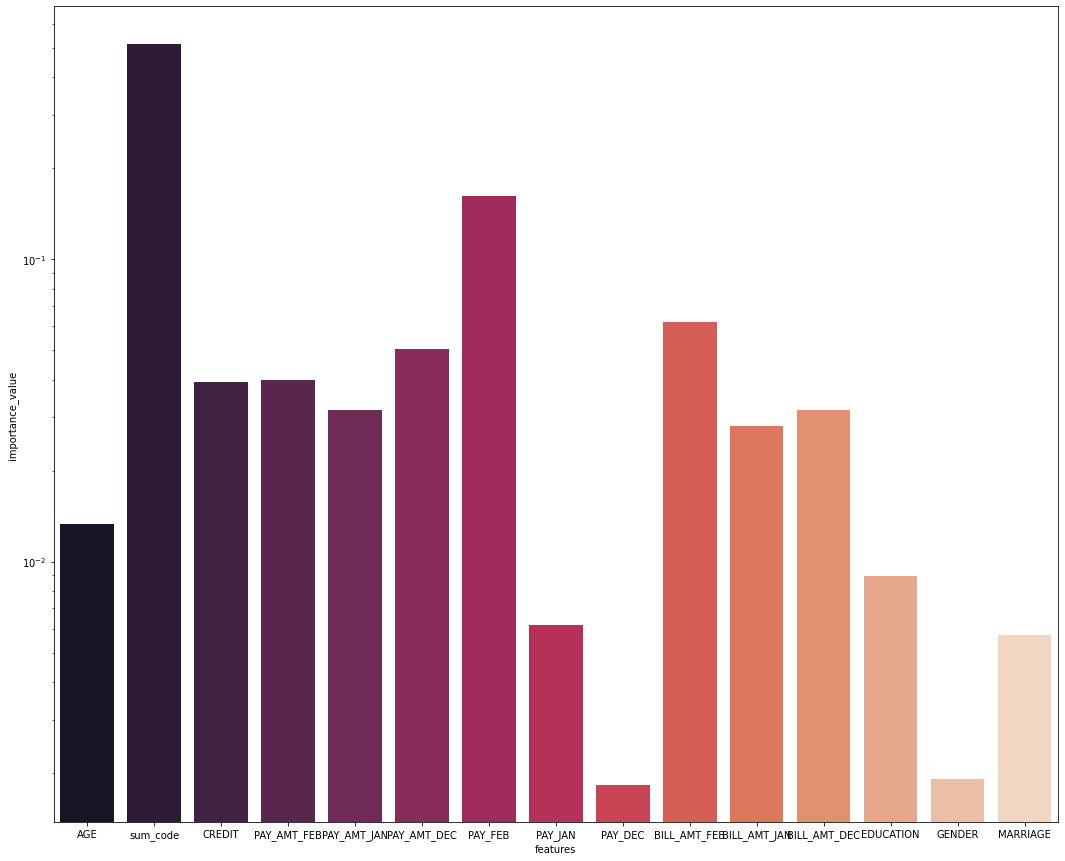

In [31]:
## Also lets look at the feature importance on the best model
df_feature_importance= pd.DataFrame({"features":features,"importance_value":best_model.feature_importances_})
print(df_feature_importance.sort_values("importance_value",ascending=False))
plt.figure(figsize = (18,15))
g = sns.barplot(x="features", y="importance_value",
                data=df_feature_importance, 
                                   palette="rocket")
g.set_yscale("log")

In [32]:
df_test=pd.read_csv("credit_history_test.csv")
print(nulldata(df_test))
print("Total no of records ",len(df_test))

              Total  Percent
PAY_AMT_DEC       0      0.0
PAY_AMT_JAN       0      0.0
PAY_AMT_FEB       0      0.0
BILL_AMT_DEC      0      0.0
BILL_AMT_JAN      0      0.0
BILL_AMT_FEB      0      0.0
PAY_DEC           0      0.0
PAY_JAN           0      0.0
PAY_FEB           0      0.0
AGE               0      0.0
MARRIAGE          0      0.0
EDUCATION         0      0.0
GENDER            0      0.0
CREDIT            0      0.0
ID                0      0.0
Total no of records  15000


In [33]:
# Transforming the variables
df_test["MARRIAGE"]=pd.factorize(df_test["MARRIAGE"])[0]
df_test["GENDER"]=pd.factorize(df_test["GENDER"])[0]
df_test["EDUCATION"]=pd.factorize(df_test["EDUCATION"])[0]
df_test["sum_code"]=df_test.apply(lambda row:row.PAY_FEB+row.PAY_JAN+row.PAY_DEC,axis=1)

In [34]:
df_test=df_test[features]
df_test.head()

,AGE,sum_code,CREDIT,PAY_AMT_FEB,PAY_AMT_JAN,PAY_AMT_DEC,PAY_FEB,PAY_JAN,PAY_DEC,BILL_AMT_FEB,BILL_AMT_JAN,BILL_AMT_DEC,EDUCATION,GENDER,MARRIAGE
0,22,-3,50000,10000,1175,2000,-1,-1,-1,24763,33542,30455,0,0,0
1,24,-3,80000,5000,4176,4000,-1,-1,-1,75356,78236,77700,0,0,0
2,28,-3,90000,1500,1500,1508,-1,-1,-1,24657,25743,26406,1,0,1
3,27,-3,50000,493,493,493,-1,-1,-1,492,492,492,1,0,1
4,32,-3,270000,6500,6843,6284,-1,-1,-1,116315,119103,122249,1,0,1


In [35]:
df_preds = df_test.copy()
df_preds["preds"]=list(best_model.predict(df_preds))

In [36]:
df_preds["preds"].value_counts()

0    12759
1     2241
Name: preds, dtype: int64

As we see in the test data almost 12838 SMEs will not Default in march and only 2162 SMEs will default which is about ~14.9% of the SMEs

#### Few next steps of Improvement.

1. Gridsearch on the Gradient Boosting best model
2. Develop some feature based on % of payments and check if those make any impact

### Grid Search on the best model 

For any Gradient Boosting Classifier there are 3 different kinds of parameters to be tuned
1. Tree-Specific Parameters: Min sample split, max depth, leaf nodes etc
2. Boosting Parameters: learning rate, sampling rate etc
3. Miscellaneous Parameters: loss, random state etc.

We will focus on tree specific parameters only for the time being. 

The data is the 50:50 class distribution data as we obtain from the best model above

In [37]:
from sklearn.model_selection import cross_val_score
import numpy as np
df_final = pd.concat([df_no_default.sample(round(len(df_default)*0.5/(1-0.5))),df_default])

In [38]:
cv_score = cross_val_score(best_model, df_final[features], df_final[class_tag], cv=5, scoring='roc_auc')

In [39]:
print(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

0.7503226912119221 0.015250792774658743 0.7309215428446199 0.7755029585798818


In [45]:
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=20,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_final[features], df_final[class_tag])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=20,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(10, 101, 10)},
             scoring='roc_auc')

In [46]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 20}, 0.7529341190412415)

In [47]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_final[features], df_final[class_tag])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=20,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='roc_auc')

In [48]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_samples_split': 800}, 0.7533734976177141)

In [50]:
param_test3 = {'min_samples_split':range(600,1800,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_final[features], df_final[class_tag])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7,
                                                  max_features='sqrt',
                                                  n_estimators=50,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(600, 1800, 200)},
             scoring='roc_auc')

In [51]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 1400}, 0.755349071192604)

In [53]:
gsearch3.best_estimator_.fit(df_final[features], df_final[class_tag]).feature_importances_

array([0.01314916, 0.22352928, 0.03878358, 0.05963571, 0.03202073,
       0.06320676, 0.27324335, 0.1041683 , 0.09228614, 0.02865634,
       0.02640567, 0.02243258, 0.01233525, 0.00213983, 0.00800732])

In [52]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=13, min_samples_split=1400, min_samples_leaf=30, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_final[features], df_final[class_tag])
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 9}, 0.7552447571042443)

        features  importance_value
6        PAY_FEB          0.273243
1       sum_code          0.223529
7        PAY_JAN          0.104168
8        PAY_DEC          0.092286
5    PAY_AMT_DEC          0.063207
3    PAY_AMT_FEB          0.059636
2         CREDIT          0.038784
4    PAY_AMT_JAN          0.032021
9   BILL_AMT_FEB          0.028656
10  BILL_AMT_JAN          0.026406
11  BILL_AMT_DEC          0.022433
0            AGE          0.013149
12     EDUCATION          0.012335
14      MARRIAGE          0.008007
13        GENDER          0.002140


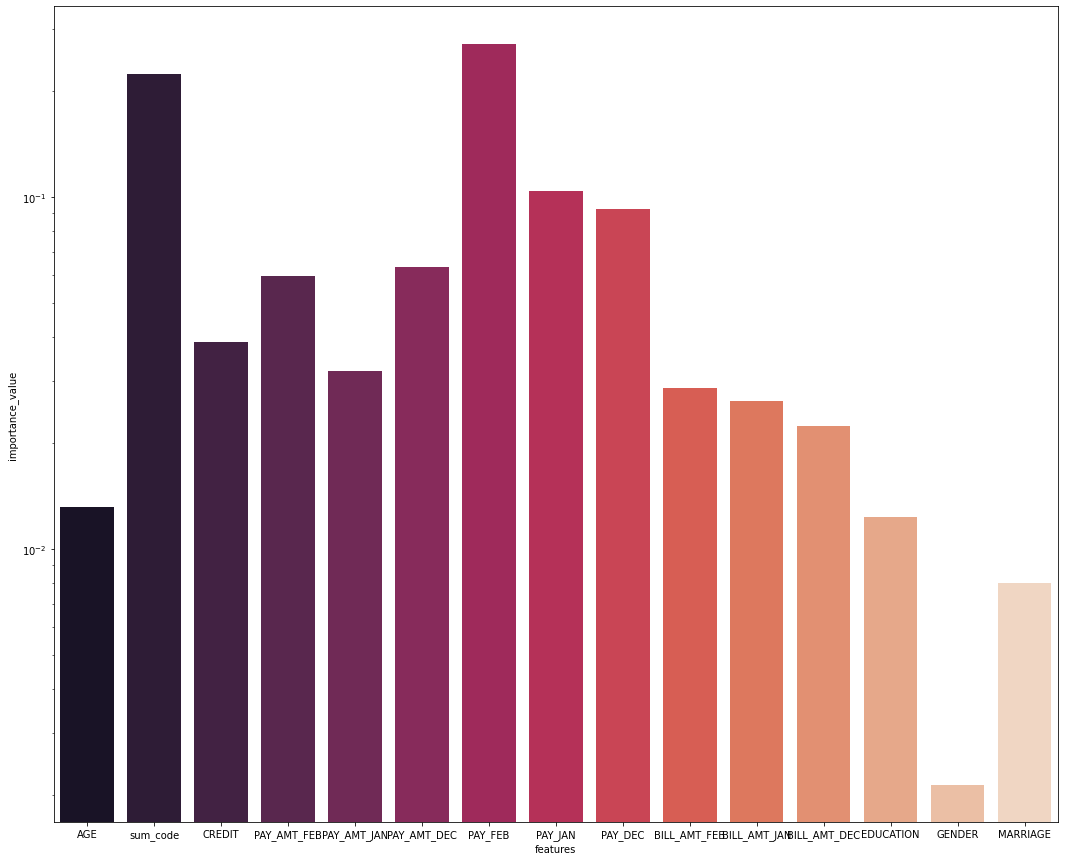

In [54]:
## Since the score dipped we are using the previous model to predict
df_feature_importance_gs= pd.DataFrame({"features":features,"importance_value":gsearch3.best_estimator_.fit(df_final[features], df_final[class_tag]).feature_importances_})
print(df_feature_importance_gs.sort_values("importance_value",ascending=False))
plt.figure(figsize = (18,15))
g = sns.barplot(x="features", y="importance_value",
                data=df_feature_importance_gs, 
                                   palette="rocket")
g.set_yscale("log")


In [55]:
preds = (gsearch3.best_estimator_.predict(df_test))

In [56]:
df_preds1 = df_test.copy()
df_preds1["preds"]=preds

In [57]:
df_preds1["sum_code"]=df_preds1.apply(lambda row:row.PAY_FEB+row.PAY_JAN+row.PAY_DEC,axis=1)
perc_tab,data_tab=get_data_crosstab(df_preds1,"preds","sum_code")
pd.DataFrame(perc_tab).transpose().reset_index().sort_values("DEFAULT",ascending=False)

preds,sum_code,NO_DEFAULT,DEFAULT,All
10,8,0.000000,1.000000,1.0
18,18,0.000000,1.000000,1.0
16,15,0.000000,1.000000,1.0
15,13,0.000000,1.000000,1.0
14,12,0.000000,1.000000,1.0
13,11,0.000000,1.000000,1.0
12,10,0.000000,1.000000,1.0
11,9,0.000000,1.000000,1.0
9,7,0.000000,1.000000,1.0
8,6,0.000000,1.000000,1.0


In [58]:
df_preds1["preds"].value_counts()

0    10814
1     4186
Name: preds, dtype: int64

### Conclusion

We obtain 3 different types of model. The baseline one which was improved by the Gradient Boosting model which incorporated the undersampling technique to handle class imbalance and then finally another Gradient Boosting model optimized on its various tree based hyperparameters.

We see the the GB model vs Grid Search GB model there is a change in the feature importance. In the first case where SUM_CODE (***an engineered feature to ascertain payment continuity***) was important at almost 55%, more than all the other features combined in the Grid Search model the importance across many variables are fairly distributed with other features about payment delays and payment amounts of the recent months

With regard to final predictions, in the GB model the percentage of DEFAULT in MAR is 14% vs 27.9% in the Grid Search GB model. Given false negatives (classifying defaults as non defaults) are costlier in this case the conservative model can be preferred over the GB model. However if the underwriting apetite is low we can prefer the lenient model